# CNN model baseline

## Loading in

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from random import randint
import albumentations as A
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
!pip install --upgrade tensorflow

In [ ]:
#mount my drive

from google.colab import drive

drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
#moving the images to the Google Colab VM
!unzip "/content/drive/My Drive/Thesis/images_by_AR.zip" -d "/content"


In [ ]:
#the subsetted datasets (created in EDA notebook)

train = pd.read_csv('/content/drive/My Drive/Thesis/train_us.csv')
test_us = pd.read_csv('/content/drive/My Drive/Thesis/test_us.csv')
test_imb = pd.read_csv('/content/drive/My Drive/Thesis/test_imbalanced.csv')
val = pd.read_csv('/content/drive/My Drive/Thesis/val_us.csv')

print (len(train))
print (len(val))
print (len(test_us))
print (len(test_imb))

74650
11243
9399
24175


In [ ]:
#checking if everything was moved to the VM successfully
dir = '/content/images_by_AR/'
missing_images = [filename for filename in filenames if not os.path.exists(os.path.join(dir, filename))]
print(f"Missing images: {missing_images}")


Missing images: []


## Dataset creation

In [ ]:
#set up the augmentation pipeline
def augment (img):
  """Have the image augmented with random augmentation"""

  augmentations = A.Compose(
      [A.HorizontalFlip (p = 0.5), #random horizontal flip with a chance of 50%
       A.VerticalFlip(p=0.5), #vertical flip (chance of 50%)
       A.Rotate (limit=(-90,90), interpolation=cv.INTER_CUBIC, border_mode=cv.BORDER_REFLECT, p=0.5)] #rotation with range [-90,90]
  )

  augmented = augmentations(image=img)['image'] #run the image though this pipeline

  return augmented

In [ ]:

import tensorflow as tf
import pandas as pd
import cv2
import numpy as np

dir = '/content/images_by_AR/'

# Function to load and process images

def load_and_process_image(filename, label):
    # Decode the filename from bytes to string
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    # Read the image
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    # Convert image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = augment(img) #augment image

    img = img.astype(np.float32) / 255.0 #normalize image

    return img, label

# Create a tf.data.Dataset from the CSV
filenames = train['filename'].values
labels = train['class'].values

# Convert filenames and labels to TensorFlow Tensors
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# Map the loading and processing function
def map_func(filename, label):
    img, label = load_and_process_image(filename.numpy(), label.numpy())
    return img, label

# Apply tf.py_function because the fuction was made for numpy arrays, and not tf's
dataset = dataset.map(
    lambda filename, label: tf.py_function(
        func=map_func, inp=[filename, label], Tout=[tf.float32, tf.int64]
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

def set_shapes(img, label): #this is needed because tensorflow does not recognize shapes automatically after applying tf.py_function
    img.set_shape((224, 224, 3))  # Set the shape for the image
    label.set_shape(())  # Set the shape for the label (scalar)
    return img, label

dataset = dataset.map(set_shapes)

# Batch and prefetch the dataset for performance
dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

#test if the batches are sucessfully fetched
for images, labels in dataset.take(1):
    print ('batch fetched')


batch fetched


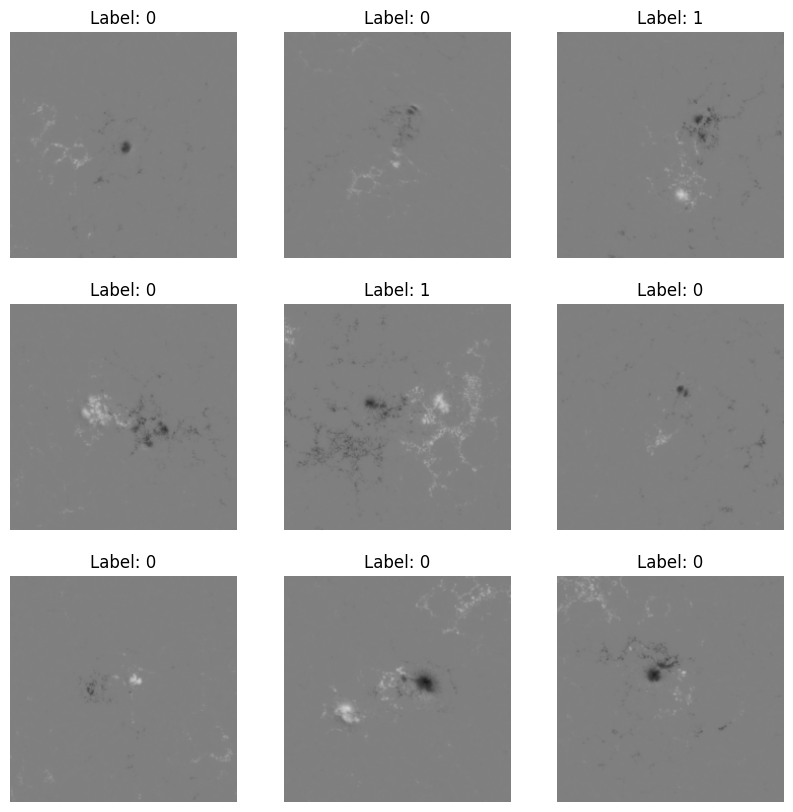

In [ ]:
import matplotlib.pyplot as plt

# Function to plot a grid of 9 images
def display_batch_of_images(images, labels):
    plt.figure(figsize=(10, 10))

    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")  # Hide axes

    plt.show()

# Fetch one batch of images and labels
for images, labels in dataset.take(1):
    display_batch_of_images(images, labels)
    break


In [ ]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

#loading in images and preprocess them
def load_and_process_image_val(filename, label):
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    #image loading
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    #convert to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #normalize the image to 0, 1
    img = img.astype(np.float32) / 255.0


    return img, label

#convert these filenames and labels to np arrays to pass to the map (), because the preprocessing functions need np arrays and not tensors
def map_func_val(filename, label):
    img, label = load_and_process_image_val(filename.numpy(), label.numpy())
    return img, label

#get the filenames and labels to use in the functions created above
filenames_val = val['filename'].values
labels_val = val['class'].values

#make the datasets (turns filenames and labels to tensors)
val_dataset = tf.data.Dataset.from_tensor_slices((filenames_val, labels_val))

def process_image_and_label_val(filename, label):
    #apply the function
    img, label = tf.py_function(func=map_func_val, inp=[filename, label], Tout=[tf.float32, tf.int64])

    #set this shape because they get lost in the tf.py_function and otherwise the model cannot read the shapes
    img.set_shape([224, 224, 3])
    label.set_shape([])

    return img, label

#map the function to the dataset so everything is processed
val_dataset = val_dataset.map(process_image_and_label_val)

val_dataset = val_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

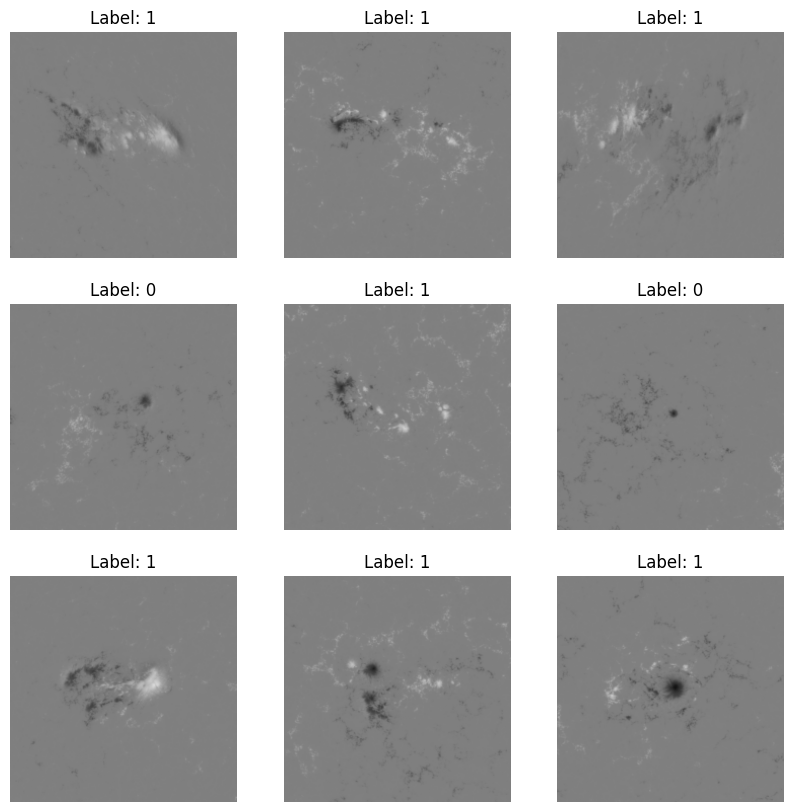

In [ ]:
for images, labels in val_dataset.take(1):
    display_batch_of_images(images, labels)
    break

In [ ]:
#check if the shapes can be recognized by tf.data.Dataset

for img, label in test_dataset.take(1):
  print (img.shape)
  print (label.shape)


val_dataset.element_spec

(32, 224, 224, 3)
(32,)


(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
for img, label in val_dataset.take(1):  # Take one batch
    print(f"Validation batch shape: {img.shape}, Labels: {label.numpy()}")
#take a look at labels and shapes for 1 batch

Validation batch shape: (64, 224, 224, 3), Labels: [1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0
 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0]


## Final model

In [ ]:
recall = keras.metrics.Recall()
precision = keras.metrics.Precision()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers

#load model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#freeze all layers
for layer in vgg16_model.layers:
    layer.trainable = False

#access last trainable layer and unfreeze it
for layer in vgg16_model.layers[-2:]:
    layer.trainable = True

#create the model
inputs = layers.Input(shape=(224, 224, 3))
x = vgg16_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(0.0001))(x)  #add classification head

model = models.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 2,360,321 (9.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [ ]:
import keras

learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.000001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile (optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', recall, precision])

history = model.fit (dataset, validation_data = val_dataset, epochs = 20,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=10),
                        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/CNN_model_best.keras', save_best_only=True), #best model is saved to make predictions in result notebook
                        learning_rate_s],
                     verbose = 1, shuffle = True)

import pandas as pd
######################
# Save history to a DataFrame
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/training_history_CNN.csv', index=False)

Epoch 1/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 723s 302ms/step - accuracy: 0.7271 - loss: 0.5367 - precision_1: 0.7490 - recall_1: 0.6785 - val_accuracy: 0.7675 - val_loss: 0.4894 - val_precision_1: 0.7864 - val_recall_1: 0.7346 - learning_rate: 1.0000e-04
Epoch 2/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 686s 285ms/step - accuracy: 0.7638 - loss: 0.4932 - precision_1: 0.7857 - recall_1: 0.7212 - val_accuracy: 0.7704 - val_loss: 0.4862 - val_precision_1: 0.7840 - val_recall_1: 0.7465 - learning_rate: 1.0000e-04
Epoch 3/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 679s 284ms/step - accuracy: 0.7678 - loss: 0.4854 - precision_1: 0.7875 - recall_1: 0.7294 - val_accuracy: 0.7735 - val_loss: 0.4827 - val_precision_1: 0.7977 - val_recall_1: 0.7328 - learning_rate: 1.0000e-04
Epoch 4/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 637s 273ms/step - accuracy: 0.7700 - loss: 0.4814 - precision_1: 0.7895 - recall_1: 0.7323 - val_accuracy: 0.7710 - val_loss: 0.4819 - val_precision_1: 0.7998 - val_recall_1: 0.7229 - learning_rate: 1.0

Performances are in the results notebook